# Model Metrics Visualization

This notebook visualizes precision, recall, and F1 scores for labels 0-5 from saved model metrics.

### Load and init modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from pathlib import Path
import sys
from typing import Any, Dict, List, Optional, Tuple

sys.path.append(str(Path.cwd().parent.parent))
from models.encoder.metrics_helper import (
    aggregate_metrics_by_model,
    sort_aggregated_models,
    extract_per_label_metrics,
    get_confusion_matrix,
    load_cv_data,
    load_cv_history_files,
    load_train_data,
    load_train_history_files,
)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 5)

/home/terra/Projects/vis-desc/modules/lab/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### List metrics

In [2]:
aggregated_models = aggregate_metrics_by_model()
aggregated_models = sort_aggregated_models(aggregated_models)

print(f"\nFound {len(aggregated_models)} model configurations:")
for i, m in enumerate(aggregated_models):
    splits = [s for s in ["train", "val", "test"] if m.get(s) is not None]
    print(f"  [{i}] {m['model']} (splits: {', '.join(splits) if splits else 'none'})")


Found 18 model configurations:
  [0] random (splits: train, val, test)
  [1] random_lg (splits: train, val, test)
  [2] ridge_minilm (splits: train, val, test)
  [3] ridge_minilm_lg (splits: train, val, test)
  [4] ridge_mbert (splits: train, val, test)
  [5] ridge_mbert_lg (splits: train, val, test)
  [6] rf_minilm (splits: train, val, test)
  [7] rf_minilm_lg (splits: train, val, test)
  [8] rf_mbert (splits: train, val, test)
  [9] rf_mbert_lg (splits: train, val, test)
  [10] svm_minilm (splits: train, val, test)
  [11] svm_mbert (splits: train, val, test)
  [12] catboost_minilm (splits: train, val, test)
  [13] catboost_minilm_lg (splits: train, val, test)
  [14] catboost_mbert (splits: train, val, test)
  [15] catboost_mbert_lg (splits: train, val, test)
  [16] finetuned-mbert (splits: train, test)
  [17] finetuned-mbert_lg (splits: train, val, test)


## Specific model

### Utilities

In [ ]:
def vis_specific_model_tables(
    metrics_data: dict[str, Any], train_df=None, cv_df=None, test_df=None
):
    print("=" * 60)
    print("TRAIN METRICS")
    print("=" * 60)

    def _styled_no_index(df):
        """
        Return a Styler that formats columns and hides the row index by CSS.
        This avoids using Styler.hide_index() which may not be available in older pandas.
        """
        fmt = {
            "Precision": "{:.4f}",
            "Recall": "{:.4f}",
            "F1": "{:.4f}",
            "Support": "{:d}",
        }
        return df.style.format(fmt).set_table_styles(
            [{"selector": "th.row_heading, th.blank", "props": [("display", "none")]}]
        )

    if train_df is not None:
        display(_styled_no_index(train_df))
        if metrics_data.get("train") is not None:
            print(f"Accuracy: {metrics_data['train']['accuracy']:.4f}")
            print(f"MSE: {metrics_data['train']['mse']:.4f}")

    print("\n" + "=" * 60)
    print("CROSS-VALIDATION METRICS (Averaged Across Folds)")
    print("=" * 60)
    if cv_df is not None:
        display(_styled_no_index(cv_df))
        if metrics_data.get("val") is not None:
            print(f"Accuracy: {metrics_data['val']['accuracy']:.4f}")
            print(f"MSE: {metrics_data['val']['mse']:.4f}")

    print("\n" + "=" * 60)
    print("TEST METRICS")
    print("=" * 60)
    if test_df is not None:
        display(_styled_no_index(test_df))
        if metrics_data.get("test") is not None:
            print(f"Accuracy: {metrics_data['test']['accuracy']:.4f}")
            print(f"MSE: {metrics_data['test']['mse']:.4f}")

    # Display per-fold CV metrics if available
    if metrics_data.get("val") and "folds" in metrics_data["val"]:
        print("\n" + "=" * 60)
        print("CROSS-VALIDATION METRICS - PER FOLD")
        print("=" * 60)

        folds_data = metrics_data["val"]["folds"]
        n_folds = len(folds_data)

        for fold_idx, fold_metrics in enumerate(folds_data):
            print(f"\n--- Fold {fold_idx + 1}/{n_folds} ---")

            fold_df = pd.DataFrame(
                {
                    "Label": range(6),
                    "Precision": fold_metrics.get("precision", [])[:6],
                    "Recall": fold_metrics.get("recall", [])[:6],
                    "F1": fold_metrics.get("f1", [])[:6],
                    "Support": fold_metrics.get("support", [])[:6],
                }
            )

            display(_styled_no_index(fold_df))
            print(f"Accuracy: {fold_metrics['accuracy']:.4f}")
            print(f"MSE: {fold_metrics['mse']:.4f}")


def plot_confusion_matrix(metrics_dict, dataset="test"):
    """
    Plot confusion matrix showing hits (diagonal) and misses (off-diagonal).

    Args:
        metrics_dict: Dictionary containing model metrics
        dataset: Which dataset to use ('train', 'val', or 'test')
    """
    cm = get_confusion_matrix(metrics_dict, dataset)
    if cm is None:
        print(f"Warning: {dataset} not available for this model")
        return

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax1,
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={"label": "Count"},
    )
    ax1.set_title(
        f"{metrics_dict['model']} - Confusion Matrix ({dataset.replace('_', ' ').title()})\n(Raw Counts)",
        fontsize=14,
        fontweight="bold",
    )
    ax1.set_xlabel("Predicted Label", fontsize=12)
    ax1.set_ylabel("True Label", fontsize=12)
    ax1.set_xticklabels([f"Label {i}" for i in range(6)])
    ax1.set_yticklabels([f"Label {i}" for i in range(6)])

    # Plot 2: Normalized confusion matrix (by true label)
    cm_normalized = cm.astype("float")
    row_sums = cm.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    cm_normalized = cm_normalized / row_sums

    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".2f",
        cmap="RdYlGn",
        ax=ax2,
        linewidths=0.5,
        linecolor="gray",
        cbar_kws={"label": "Proportion"},
        vmin=0,
        vmax=1,
    )
    ax2.set_title(
        f"{metrics_dict['model']} - Normalized Confusion Matrix ({dataset.replace('_', ' ').title()})\n(Proportion of True Label)",
        fontsize=14,
        fontweight="bold",
    )
    ax2.set_xlabel("Predicted Label", fontsize=12)
    ax2.set_ylabel("True Label", fontsize=12)
    ax2.set_xticklabels([f"Label {i}" for i in range(6)])
    ax2.set_yticklabels([f"Label {i}" for i in range(6)])

    plt.tight_layout()
    plt.show()

    total = cm.sum()
    correct = np.trace(cm)
    accuracy = correct / total if total > 0 else 0

    print("\nConfusion Matrix Statistics:")
    print(f"  Total predictions: {total}")
    print(f"  Correct predictions (diagonal): {correct}")
    print(f"  Incorrect predictions (off-diagonal): {total - correct}")
    print(f"  Accuracy: {accuracy:.4f}")
    print("\nPer-label statistics:")
    for i in range(6):
        true_count = cm[i, :].sum()
        correct_count = cm[i, i]
        if true_count > 0:
            per_label_acc = correct_count / true_count
            print(
                f"  Label {i}: {correct_count}/{true_count} correct ({per_label_acc:.2%})"
            )
        else:
            print(f"  Label {i}: No samples")


def vis_specific_model_conf_matrices(
    metrics_data: dict[str, Any], train_df=None, cv_df=None, test_df=None
):
    print("=" * 80)
    print("TRAIN SET CONFUSION MATRIX")
    print("=" * 80)
    plot_confusion_matrix(metrics_data, "train")

    print("\n" + "=" * 80)
    print("CROSS-VALIDATION CONFUSION MATRIX")
    print("=" * 80)
    plot_confusion_matrix(metrics_data, "val")

    print("\n" + "=" * 80)
    print("TEST SET CONFUSION MATRIX")
    print("=" * 80)
    plot_confusion_matrix(metrics_data, "test")

### Runner

In [ ]:
# Select a model index to visualize
MODEL_INDEX = 1 if len(aggregated_models) > 1 else 0
metrics_data = aggregated_models[MODEL_INDEX]

train_df = extract_per_label_metrics(metrics_data, "train")
cv_df = extract_per_label_metrics(metrics_data, "val")
test_df = extract_per_label_metrics(metrics_data, "test")

print(f"Model: {metrics_data['model']}")
print(f"Parameters: {metrics_data['params']}")

In [ ]:
# Tables
vis_specific_model_tables(metrics_data, train_df, cv_df, test_df)

In [ ]:
# Confusion Matrices
vis_specific_model_conf_matrices(metrics_data, train_df, cv_df, test_df)

## All models

### Utilities

In [13]:
def vis_all_models_plots(models, dataset="test"):
    """
    Compare per-label metrics across multiple aggregated model dicts.
    """
    models_data = []
    lg_models_data = []
    for m in models:
        if m.get(dataset) is not None:
            if "_lg" in m["model"]:
                lg_models_data.append({"model": m["model"], "metrics": m[dataset]})
            else:
                models_data.append({"model": m["model"], "metrics": m[dataset]})
    if not models_data:
        print(f"No models with {dataset} available")
        return

    # Create a lookup for _lg models by their base name
    lg_lookup = {}
    for lg_md in lg_models_data:
        base_name = lg_md["model"].replace("_lg", "")
        lg_lookup[base_name] = lg_md

    def parse_model(name: str):
        parts = name.split("_")
        if len(parts) >= 2:
            return parts[0], parts[1]
        return parts[0], None

    base_to_models = {}
    for md in models_data:
        base, emb = parse_model(md["model"])
        base_to_models.setdefault(base, []).append((emb, md))

    MODEL_ORDER = ["random", "ridge", "rf", "svm", "catboost", "finetuned-mbert"]
    EMBED_ORDER = ["minilm", "mbert"]

    ordered_bases = [b for b in MODEL_ORDER if b in base_to_models]
    ordered_bases += [b for b in base_to_models.keys() if b not in ordered_bases]

    for base in ordered_bases:
        embeds_present = [emb for emb, _ in base_to_models[base]]
        ordered_embeds = [e for e in EMBED_ORDER if e in embeds_present]
        ordered_embeds += [e for e in embeds_present if e not in ordered_embeds]
        md_map = {emb: md for emb, md in base_to_models[base]}
        base_to_models[base] = [(emb, md_map[emb]) for emb in ordered_embeds]

    base_colors = {
        "random": "#4C78A8",
        "ridge": "#F58518",
        "rf": "#54A24B",
        "svm": "#B79F00",
        "catboost": "#E45756",
        "finetuned": "#7F3C8D",
        "finetuned-mbert": "#7F3C8D",
    }

    def darken(hex_color, factor=0.75):
        hex_color = hex_color.lstrip("#")
        r = int(hex_color[0:2], 16)
        g = int(hex_color[2:4], 16)
        b = int(hex_color[4:6], 16)
        r = int(r * factor)
        g = int(g * factor)
        b = int(b * factor)
        return f"#{r:02x}{g:02x}{b:02x}"

    total_cluster_width = 0.85
    n_bases = len(ordered_bases)
    base_slot_width = total_cluster_width / n_bases if n_bases else 0.0
    base_slot_margin_factor = 0.15

    for metric_name in ["Precision", "Recall", "F1"]:
        fig, ax = plt.subplots(figsize=(12, 6))
        for base_idx, base in enumerate(ordered_bases):
            variants = base_to_models[base]
            n_variants = len(variants)
            inner_width = base_slot_width * (1 - base_slot_margin_factor)
            bar_width = inner_width / n_variants if n_variants else inner_width * 0.5
            base_center_offset = -total_cluster_width / 2 + base_slot_width * (
                base_idx + 0.5
            )
            for v_idx, (emb, md) in enumerate(variants):
                metric_key = metric_name.lower()
                values = md["metrics"].get(metric_key, [])
                values = values + [0.0] * (6 - len(values))
                base_positions = np.arange(6) + base_center_offset
                variant_offset_start = -inner_width / 2 + v_idx * bar_width
                x_positions = base_positions + variant_offset_start
                c = base_colors.get(base, "#888888")
                if emb == "mbert":
                    c = darken(c)
                ax.bar(
                    x_positions,
                    values[:6],
                    width=bar_width,
                    label=md["model"],
                    alpha=0.9,
                    color=c,
                    edgecolor="white",
                    linewidth=0.5,
                )

                # Add horizontal line for _lg variant if exists
                lg_md = lg_lookup.get(md["model"])
                if lg_md is not None:
                    lg_values = lg_md["metrics"].get(metric_key, [])
                    lg_values = lg_values + [0.0] * (6 - len(lg_values))
                    for label_idx in range(6):
                        x_pos = x_positions[label_idx]
                        lg_val = lg_values[label_idx]

                        line_y = lg_val
                        line_left = x_pos - bar_width / 2
                        line_right = x_pos + bar_width / 2

                        ax.plot(
                            [line_left, line_right],
                            [line_y, line_y],
                            color="black",
                            linewidth=2,
                            zorder=10,
                        )

        ax.set_xlabel("Label", fontsize=12)
        ax.set_ylabel(metric_name, fontsize=12)
        ax.set_title(
            f"{metric_name} Across Models ({dataset.replace('_', ' ').title()} Dataset)",
            fontsize=14,
            fontweight="bold",
        )
        ax.set_xticks(np.arange(6))
        ax.set_xticklabels([f"Label {i}" for i in range(6)])
        ax.set_ylim(0, 1.0)
        ax.grid(axis="y", alpha=0.3)
        handles, labels = ax.get_legend_handles_labels()
        seen = set()
        new_handles, new_labels = [], []
        for h, label in zip(handles, labels):
            if label not in seen:
                seen.add(label)
                new_handles.append(h)
                new_labels.append(label)
        ax.legend(new_handles, new_labels, fontsize=10, ncol=2)
        plt.tight_layout()
        plt.show()

    flat_models = []
    for base in ordered_bases:
        for emb, md in base_to_models[base]:
            flat_models.append((base, emb, md))

    def build_cluster_positions():
        positions = []
        for base_idx, base in enumerate(ordered_bases):
            variants = [t for t in flat_models if t[0] == base]
            n_variants = len(variants)
            inner_width = base_slot_width * (1 - base_slot_margin_factor)
            bar_width = inner_width / n_variants if n_variants else inner_width * 0.5
            base_center_offset = -total_cluster_width / 2 + base_slot_width * (
                base_idx + 0.5
            )
            for v_idx, (b, emb, md) in enumerate(variants):
                variant_offset_start = -inner_width / 2 + v_idx * bar_width
                pos = base_center_offset + variant_offset_start
                positions.append((b, emb, md, pos, bar_width))
        return positions

    n_bases = len(ordered_bases)
    clustered_positions = build_cluster_positions()
    variant_positions = [pos for _, _, _, pos, _ in clustered_positions]
    variant_labels = []
    for base, emb, md, pos, bw in clustered_positions:
        if emb is None:
            variant_labels.append(f"{base}")
        else:
            variant_labels.append(f"{base}\n({emb})")

    def plot_single_metric(metric_key, title, ylim=None, transform=None, y_label=None):
        fig, ax = plt.subplots(figsize=(12, 6))
        for base, emb, md, pos, bw in clustered_positions:
            val = md["metrics"].get(metric_key)
            if val is None:
                continue
            if transform:
                val = transform(val)
            c = base_colors.get(base, "#888888")
            if emb == "mbert":
                c = darken(c)
            bar = ax.bar(
                [pos],
                [val],
                width=bw,
                color=c,
                alpha=0.9,
                edgecolor="white",
                linewidth=0.5,
            )[0]
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height(),
                f"{val:.4f}",
                ha="center",
                va="bottom",
                fontsize=9,
            )

            # Add horizontal line for _lg variant if exists
            lg_md = lg_lookup.get(md["model"])
            if lg_md is not None:
                lg_val = lg_md["metrics"].get(metric_key)
                if lg_val is not None:
                    if transform:
                        lg_val = transform(lg_val)
                    line_left = pos - bw / 2
                    line_right = pos + bw / 2
                    ax.plot(
                        [line_left, line_right],
                        [lg_val, lg_val],
                        color="black",
                        linewidth=2,
                        zorder=10,
                    )

        ax.set_title(title, fontsize=14, fontweight="bold")
        ax.set_ylabel(y_label if y_label else metric_key.title(), fontsize=12)
        ax.grid(axis="y", alpha=0.3)
        if ylim:
            ax.set_ylim(*ylim)
        ax.set_xticks(variant_positions)
        ax.set_xticklabels(variant_labels, fontsize=10)
        plt.tight_layout()
        plt.show()

    plot_single_metric(
        "mse",
        f"RMSE Across Models ({dataset.replace('_', ' ').title()} Dataset)",
        transform=lambda x: np.sqrt(x),
        y_label="RMSE",
    )
    plot_single_metric(
        "accuracy",
        f"Accuracy Across Models ({dataset.replace('_', ' ').title()} Dataset)",
        ylim=(0, 1.0),
    )

    # Macro-F1
    fig, ax = plt.subplots(figsize=(12, 6))
    for base, emb, md, pos, bw in clustered_positions:
        f1_list = md["metrics"].get("f1", [])
        if not f1_list:
            continue
        macro_f1 = np.mean(f1_list)
        c = base_colors.get(base, "#888888")
        if emb == "mbert":
            c = darken(c)
        bar = ax.bar(
            [pos],
            [macro_f1],
            width=bw,
            color=c,
            alpha=0.9,
            edgecolor="white",
            linewidth=0.5,
        )[0]
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            f"{macro_f1:.4f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

        # Add horizontal line for _lg variant if exists
        lg_md = lg_lookup.get(md["model"])
        if lg_md is not None:
            lg_f1_list = lg_md["metrics"].get("f1", [])
            if lg_f1_list:
                lg_macro_f1 = np.mean(lg_f1_list)
                line_left = pos - bw / 2
                line_right = pos + bw / 2
                ax.plot(
                    [line_left, line_right],
                    [lg_macro_f1, lg_macro_f1],
                    color="black",
                    linewidth=2,
                    zorder=10,
                )

    ax.set_title(
        f"Macro-F1 Across Models ({dataset.replace('_', ' ').title()} Dataset)",
        fontsize=14,
        fontweight="bold",
    )
    ax.set_ylabel("Macro-F1", fontsize=12)
    ax.set_ylim(0, 1.0)
    ax.grid(axis="y", alpha=0.3)
    ax.set_xticks(variant_positions)
    ax.set_xticklabels(variant_labels, fontsize=10)
    plt.tight_layout()
    plt.show()


def vis_all_models_tables():
    all_metrics = []
    for m in aggregated_models:

        def _safe(dataset, key):
            d = m.get(dataset)
            if d is None:
                return np.nan
            val = d.get(key)
            return val if val is not None else np.nan

        def _rmse(dataset):
            mse = _safe(dataset, "mse")
            return np.sqrt(mse) if not pd.isna(mse) else np.nan

        def _macro_f1(dataset):
            d = m.get(dataset)
            if d and d.get("f1"):
                return float(np.mean(d["f1"]))
            return np.nan

        all_metrics.append(
            {
                "Model": m["model"],
                "Train RMSE": _rmse("train"),
                "CV RMSE": _rmse("val"),
                "Test RMSE": _rmse("test"),
                "Train Acc": _safe("train", "accuracy"),
                "CV Acc": _safe("val", "accuracy"),
                "Test Acc": _safe("test", "accuracy"),
                "Train Macro-F1": _macro_f1("train"),
                "CV Macro-F1": _macro_f1("val"),
                "Test Macro-F1": _macro_f1("test"),
            }
        )

    metrics_df = pd.DataFrame(all_metrics)

    display(
        metrics_df.style.format(
            {
                "Train RMSE": "{:.4f}",
                "CV RMSE": "{:.4f}",
                "Test RMSE": "{:.4f}",
                "Train Acc": "{:.4f}",
                "CV Acc": "{:.4f}",
                "Test Acc": "{:.4f}",
                "Train Macro-F1": "{:.4f}",
                "CV Macro-F1": "{:.4f}",
                "Test Macro-F1": "{:.4f}",
            }
        ).set_caption("Model Metrics Comparison")
    )

### Runner

In [ ]:
# Per-label precision, recall, F1 and per-model RMSE, accuracy, macro-F1 plots
vis_all_models_plots(aggregated_models, "test")

In [14]:
# Summary tables
vis_all_models_tables()

,Model,Train RMSE,CV RMSE,Test RMSE,Train Acc,CV Acc,Test Acc,Train Macro-F1,CV Macro-F1,Test Macro-F1
0,random,2.3129,2.4653,2.3322,0.1760,0.1734,0.1985,0.1762,0.1580,0.1981
1,random_lg,2.5940,2.4653,2.5179,0.1937,0.1734,0.2176,0.1668,0.1580,0.2063
2,ridge_minilm,0.5251,0.9334,0.9445,0.6760,0.4160,0.4389,0.6699,0.4110,0.4304
3,ridge_minilm_lg,0.7297,0.9972,0.9796,0.5951,0.4265,0.4389,0.5797,0.4460,0.4484
4,ridge_mbert,0.5226,0.9282,0.9512,0.6607,0.4159,0.4046,0.6502,0.4062,0.3929
5,ridge_mbert_lg,0.7082,0.9717,0.9799,0.6029,0.4366,0.4160,0.5863,0.4489,0.4233
6,rf_minilm,0.1424,0.9792,0.9601,0.9974,0.4109,0.3969,0.9969,0.3749,0.3742
7,rf_minilm_lg,0.1702,1.3074,1.2820,0.9802,0.3924,0.3969,0.9668,0.3874,0.3906
8,rf_mbert,0.0320,0.9728,0.9502,1.0000,0.4212,0.4389,1.0000,0.3929,0.4092
9,rf_mbert_lg,0.3779,1.3617,1.2211,0.7978,0.3599,0.3740,0.7967,0.3581,0.3704


## Training and Validation Curves

### Utilities

In [10]:
def plot_train_val_runs(
    runs: List[Dict[str, Any]],
    title: str,
    x_label: str = "Step",
    y_label: str = "Loss",
    ax: Optional[plt.Axes] = None,
) -> plt.Axes:
    """
    Plot one or more training/validation loss curves on a single axis.

    Each item in runs can contain:
      - label: name of the run
      - train: {"y": list[float], "x": list[float] | None, "mark_best": bool}
      - val: {"y": list[float], "x": list[float] | None, "mark_best": bool}
    """
    if not runs:
        print("No runs provided for plotting")
        return ax if ax is not None else None

    if ax is None:
        _, ax = plt.subplots(figsize=(12, 7))

    n_colors = max(1, min(len(runs), 10))
    colors = cm.tab10(np.linspace(0, 1, n_colors))

    for idx, run in enumerate(runs):
        color = colors[idx % len(colors)]
        label = run.get("label", f"Run {idx + 1}")

        def _plot_series(series: Optional[Dict[str, Any]], kind: str) -> None:
            if not series:
                return
            y = series.get("y") or []
            if len(y) == 0:
                return
            x = series.get("x") or list(range(1, len(y) + 1))

            style = "-o" if kind == "train" else "-s"
            alpha = 0.85 if kind == "train" else 0.7
            plot_color = color if kind == "train" else "orange"
            ax.plot(
                x,
                y,
                style,
                color=plot_color,
                linewidth=2,
                markersize=4,
                label=f"{kind.title()} - {label}",
                alpha=alpha,
            )

            if series.get("mark_best", True):
                best_idx = int(np.argmin(y))
                best_x = x[best_idx] if best_idx < len(x) else best_idx + 1
                best_y = y[best_idx]
                ax.axvline(
                    best_x, color=plot_color, linestyle="--", alpha=0.2, linewidth=1
                )
                ax.plot(best_x, best_y, "*", color=plot_color, markersize=10, zorder=5)

        _plot_series(run.get("train"), "train")
        _plot_series(run.get("val"), "val")

    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.grid(True, alpha=0.3)
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(fontsize=9, loc="best")
    plt.tight_layout()
    return ax


def plot_cv_folds_grid(
    cv_data_list: List[Dict[str, Any]],
    title_prefix: str = "Cross-validation runs",
) -> None:
    """
    Visualize training/validation curves for each fold across one or more CV runs.
    """
    if not cv_data_list:
        print("No CV metric files provided")
        return

    max_folds = max(len(cv.get("folds", [])) for cv in cv_data_list)
    if max_folds == 0:
        print("No folds found in provided CV data")
        return

    n_cols = min(3, max_folds)
    n_rows = (max_folds + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = np.array(axes).flatten() if max_folds > 1 else np.array([axes])

    for fold_idx in range(max_folds):
        ax = axes[fold_idx]
        runs: List[Dict[str, Any]] = []

        for cv_idx, cv_data in enumerate(cv_data_list):
            folds = cv_data.get("folds", [])
            if fold_idx >= len(folds):
                continue

            fold = folds[fold_idx]
            run_label = cv_data.get("model", f"CV {cv_idx + 1}")
            train_losses = fold.get("train_losses") or []
            val_losses = fold.get("val_losses") or []

            runs.append(
                {
                    "label": run_label,
                    "train": {"y": train_losses, "mark_best": True},
                    "val": {"y": val_losses, "mark_best": True},
                }
            )

        if runs:
            plot_train_val_runs(
                runs,
                title=f"Fold {fold_idx + 1}",
                x_label="Epoch",
                ax=ax,
            )
        else:
            ax.set_title(
                f"Fold {fold_idx + 1} (no data)", fontsize=12, fontweight="bold"
            )
            ax.axis("off")

    for idx in range(max_folds, len(axes)):
        axes[idx].axis("off")

    fig.suptitle(
        f"{title_prefix} - {len(cv_data_list)} run(s)",
        fontsize=16,
        fontweight="bold",
        y=1.02,
    )
    plt.tight_layout()
    plt.show()


def _batches_per_epoch(
    train_losses: List[float],
    val_losses: List[float],
    params: Dict[str, Any],
) -> int:
    batch_size = params.get("batch_size")
    n_train_samples = params.get("n_train_samples")

    if batch_size and n_train_samples:
        return max(1, int(np.ceil(n_train_samples / batch_size)))

    if train_losses and val_losses:
        return max(1, int(len(train_losses) / len(val_losses)))

    return 1


def visualize_metric_files(files: List[Path]) -> None:
    """
    Visualize 1..n metric files (train or val).

    - Train files: plot train + val curves on one figure.
    - Val files: plot per-fold train + val curves on one figure.
    - Mixed selection: produce both figures.
    """
    if not files:
        print("No files selected")
        return

    train_runs: List[Dict[str, Any]] = []
    cv_runs: List[Dict[str, Any]] = []

    for file_path in files:
        cv_data = load_cv_data(file_path)
        if cv_data and cv_data.get("folds"):
            cv_runs.append({**cv_data, "source": file_path})
            continue

        train_data = load_train_data(file_path)
        if train_data:
            params = train_data.get("params", {})
            train_losses = train_data.get("train_losses") or []
            val_losses = train_data.get("val_losses") or []
            batches_per_epoch = _batches_per_epoch(train_losses, val_losses, params)
            val_positions = [
                (i + 1) * batches_per_epoch for i in range(len(val_losses))
            ]

            train_runs.append(
                {
                    "label": train_data.get("model", file_path.stem),
                    "train": {"y": train_losses, "mark_best": True},
                    "val": {"y": val_losses, "x": val_positions, "mark_best": True},
                }
            )
        else:
            print(
                f"Warning: {file_path.name} was not recognized as train or val metrics"
            )

    if train_runs:
        print(f"Plotting {len(train_runs)} training file(s)...")
        plot_train_val_runs(train_runs, title="Training runs", x_label="Batch")

    if cv_runs:
        print(f"Plotting {len(cv_runs)} validation file(s) across folds...")
        plot_cv_folds_grid(cv_runs, title_prefix="Validation (cross-val)")

    if not train_runs and not cv_runs:
        print("Nothing to visualize after loading files")

### Runner

In [11]:
cv_history_files = load_cv_history_files()
train_history_files = load_train_history_files()

combined_files: List[Tuple[str, Path]] = []
print("Available metric files:")

for idx, f in enumerate(cv_history_files):
    combined_files.append(("val", f))
    print(f"  [{idx}] val   - {f.name}")
train_start_idx = len(combined_files)

for offset, f in enumerate(train_history_files):
    idx = train_start_idx + offset
    combined_files.append(("train", f))
    print(f"  [{idx}] train - {f.name}")

Available metric files:
  [0] val   - finetuned-mbert_lg_val_42_2025-11-30-22-16-11.json
  [1] train - finetuned-mbert_lg_train_42_2025-11-30-21-20-40.json
  [2] train - finetuned-mbert_train_40_2025-11-26-17-47-05.json
  [3] train - finetuned-mbert_train_41_2025-11-26-17-49-15.json
  [4] train - finetuned-mbert_train_42_2025-11-26-17-51-22.json


Plotting 1 validation file(s) across folds...


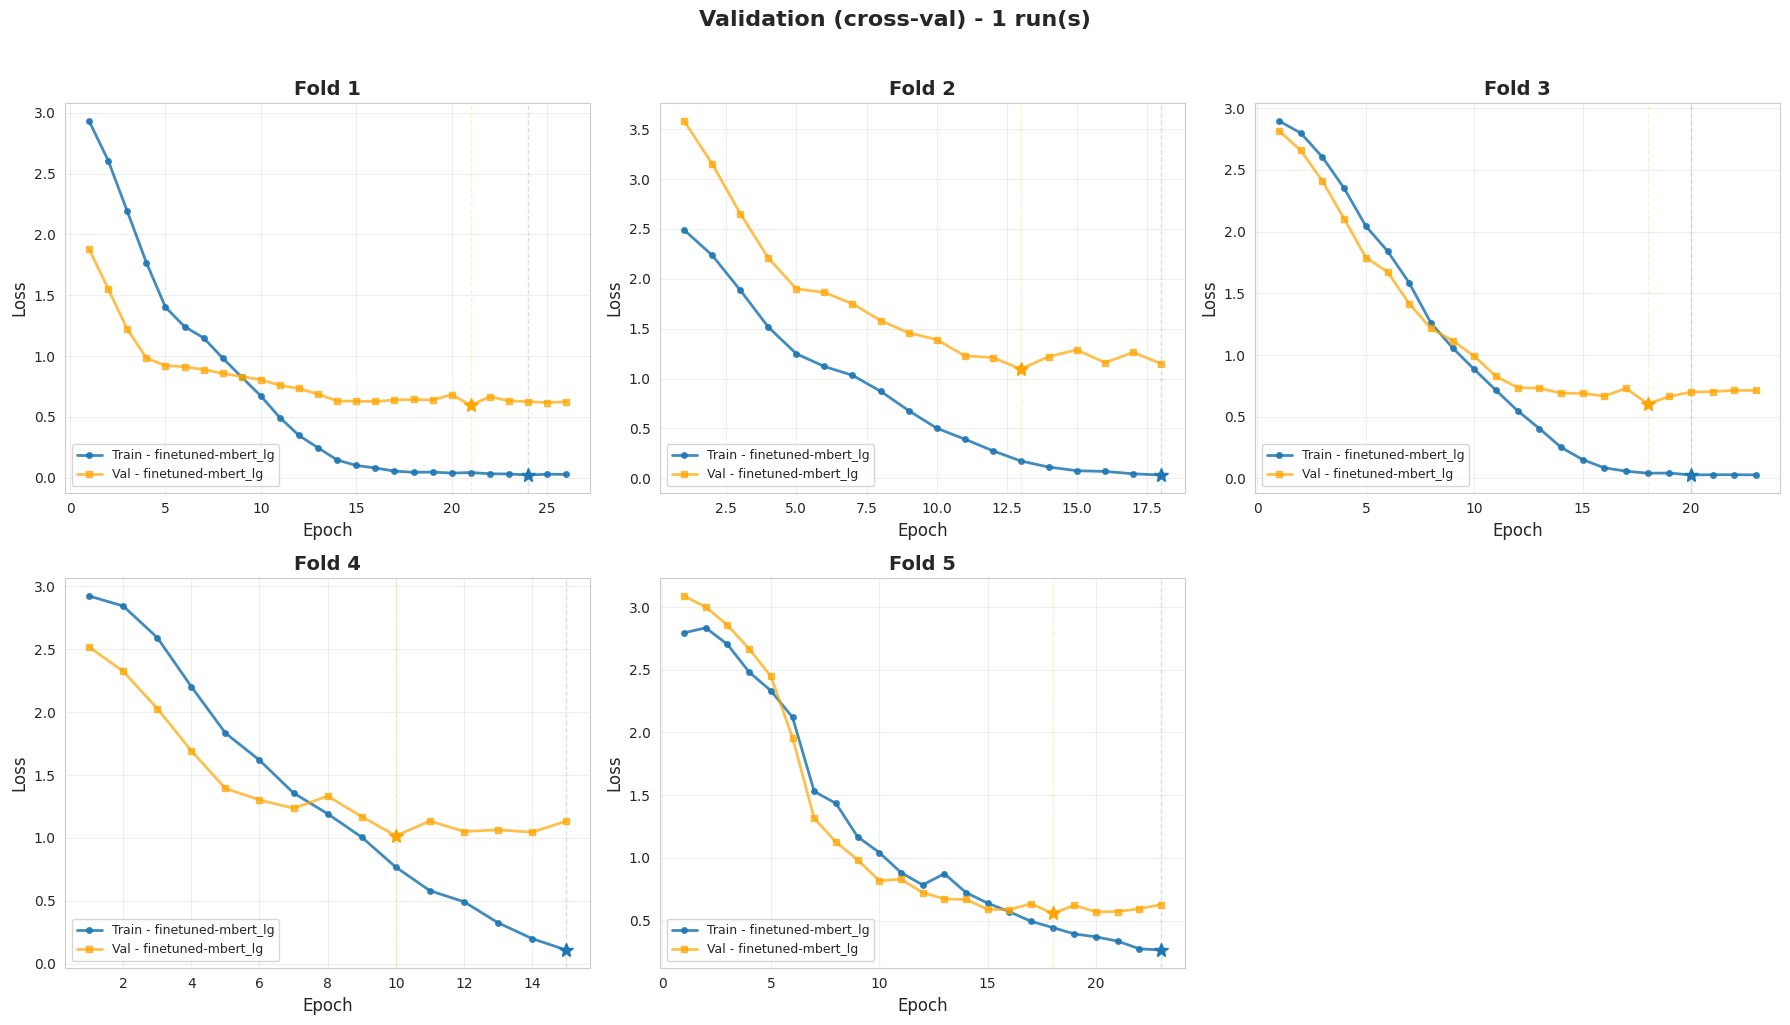

In [12]:
# Select metric files (train or val) by index and plot
SELECTED_FILE_INDICES = [0]  # e.g., [0, 3]
selected_paths = [
    combined_files[i][1] for i in SELECTED_FILE_INDICES if 0 <= i < len(combined_files)
]

visualize_metric_files(selected_paths)